# Analysis of haplotype frequencies in pseudo-soft sweeps from gene conversion and true soft sweeps from recurrent mutation

This notebook reads in the results of our Python simulations (see pipeline in this directory's README) and then calculates various summaries of sweep softness and haplotypic diversity for each parameter combination simulated.

First, we define a function to read in the data generated by the `combineAllGcAndRecMutSimResults.py` script and store the simulation outcomes.

Note: if you did not write out all of your simulation results to the default directories in this pipeline (i.e. if you changed what I had hard-coded into the python scripts), then you will have to change initialization line for baseOutDir below accordingly.

In [1]:
import os
import numpy as np
import scipy.stats

baseOutDir = "twoLocusPySims/simOutCombined/"

def parseResSummaryLine(resSummaryLine):
    resSummaryLine = resSummaryLine.rstrip()
    n1 = float(resSummaryLine.split(":")[1].split(";")[0])
    n2 = float(resSummaryLine.split(" ")[-1])
    return n1, n2

"""
    outLines.append(f"fraction of soft sweeps in pop: {resTots[0]}; fraction of soft sweeps in sample: {resTots[1]}")
    outLines.append(f"avg pop h2/h1 of soft sweeps: {resTots[2]}; avg sample h2/h1 of soft sweeps: {resTots[3]}")
    outLines.append(f"avg pop minor hap freq of soft sweeps: {resTots[4]}; avg sample minor hap freq of soft sweeps: {resTots[5]}")
    outLines.append(f"avg number of participating haps in pop: {resTots[6]}; avg number of participating haps in samp: {resTots[7]}")
"""

def parseResultsFromSimOut(simOutFile):
    with open(simOutFile) as f:
        for line in f:
            if line.startswith("fraction of soft sweeps in pop"):
                softFracPop, softFracSamp = parseResSummaryLine(line)
            elif line.startswith("avg pop h2/h1 of soft sweeps"):
                softH2H1Pop, softH2H1Samp = parseResSummaryLine(line)
            elif line.startswith("avg pop minor hap freq of soft sweeps"):
                softFreqPop, softFreqSamp = parseResSummaryLine(line)
            elif line.startswith("avg number of participating haps in pop"):
                kPop, kSamp = parseResSummaryLine(line)
    return (softFracPop, softFracSamp, softH2H1Pop, softH2H1Samp, softFreqPop, softFreqSamp, kPop, kSamp)

results = {}
for outFile in os.listdir(baseOutDir):
    params = tuple(outFile.rstrip(".out").split("_")[1:])
    results[params] = parseResultsFromSimOut(baseOutDir + "/" + outFile)

Next, we read in the simulation outcome summary file for each parameter combination and create a pandas dataframe that we will use to generate our final figures.

In [2]:
import pandas as pd

columns = "Gene Conversion Rate,Recurrent Mutation Rate,Selection Coefficient,Dominance Coefficient,Rescaling Factor,"
columns += "Fraction Soft in Sample,Fraction Soft in Pop,Mean H2/H1 Pop,Mean H2/H1 Samp,Mean Pop Hap Maf,Mean Sample Hap Maf,Mean k in Pop,Mean k in Sample"
#columns += "Fraction Soft in Sample,Fraction Soft in Pop,Mean k in Pop,Mean k in Sample"
columns = columns.split(",")

resultsForTable = []
for paramComb in results:
    #gcScalar, recMutScalar, s, h, Q = paramComb
    resultsForTable.append(paramComb + results[paramComb])
    
pd.options.display.max_rows = 999
table = pd.DataFrame(resultsForTable, columns=columns)
display(table.sort_values(
    by = ['Selection Coefficient', 'Dominance Coefficient', 'Gene Conversion Rate', 'Recurrent Mutation Rate'],
    ascending = [True, True, True, True]).fillna("NA"))

,Gene Conversion Rate,Recurrent Mutation Rate,Selection Coefficient,Dominance Coefficient,Rescaling Factor,Fraction Soft in Sample,Fraction Soft in Pop,Mean H2/H1 Pop,Mean H2/H1 Samp,Mean Pop Hap Maf,Mean Sample Hap Maf,Mean k in Pop,Mean k in Sample
0,0,0,0.001,0.0,100,0.00,0.00,0.000000,0.000000,0.000000,0.000000,1.00,1.00
18,0,1,0.001,0.0,100,0.24,0.22,0.019077,0.018842,0.033574,0.034000,1.29,1.26
9,0,10,0.001,0.0,100,0.88,0.86,0.085625,0.090518,0.178867,0.181950,3.20,2.86
36,0,5,0.001,0.0,100,0.76,0.68,0.079549,0.074420,0.146387,0.141950,2.38,2.15
27,0,50,0.001,0.0,100,1.00,1.00,0.317795,0.314003,0.523440,0.519950,10.52,8.64
54,1,0,0.001,0.0,100,1.00,0.96,0.055252,0.051154,0.137417,0.132750,6.14,4.18
45,10,0,0.001,0.0,100,1.00,1.00,0.272829,0.268444,0.600282,0.593550,46.73,26.61
72,5,0,0.001,0.0,100,1.00,1.00,0.193397,0.187553,0.444604,0.433550,25.64,15.21
63,50,0,0.001,0.0,100,1.00,1.00,0.663729,0.711858,0.910030,0.909500,175.88,80.39
1,0,0,0.001,0.5,100,0.00,0.00,0.000000,0.000000,0.000000,0.000000,1.00,1.00


Now we are just about ready to start plotting the results. First we grab all the distinct parameter values used in the sims:

In [3]:
gcRatios = sorted(table['Gene Conversion Rate'].unique(), key=float)
selCoeffs = sorted(table['Selection Coefficient'].unique(), key=float)
recMutRates = sorted(table['Recurrent Mutation Rate'].unique(), key=float)


selCoeffs = list(sorted(selCoeffs, key=float))
gcRatios = list(sorted(gcRatios, key=int))[1:]#ignore gcRatio == 0
recMutRates = list(sorted(recMutRates, key=int))[1:]#ignore gcRatio == 0
print(gcRatios)
print(recMutRates)

['1', '5', '10', '50']
['1', '5', '10', '50']


And now we write our plotting function and start generating the plots.

Note that in the plots below we are conditioning on a sweep being (pseudo-)soft when plotting H2/H1 and the mean of the summed minor haplotype frequencies. We also plot the number of distinct haplotypes at the end of the sweep (including those sweeps that had a single haplotype and thus are defined as hard), and the probability that a sweep was (pseudo-)soft (i.e. that more than one haplotype was present at the end of the sweep).

Here we go:

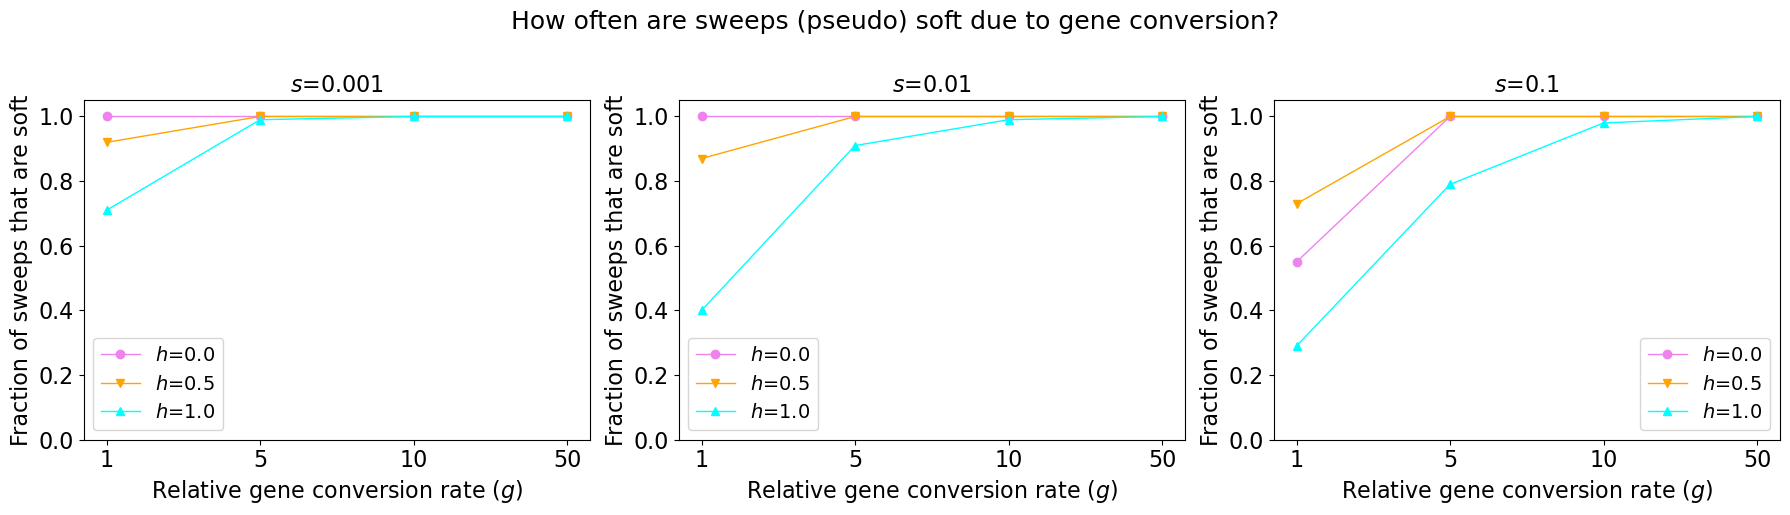

In [4]:
import matplotlib.pyplot as plt

def shortTitle(bigTitle):

    title = []
    if "often" in bigTitle:
        title.append("soft_frac")
    if "haplotypes" in bigTitle:
        title.append("num_haps")
    if "H2" in bigTitle:
        title.append("h2_h1")
    if "minor" in bigTitle:
        title.append("hap_maf")

    assert len(title) == 1

    if "conversion" in bigTitle:
        title.append("gene_conv")
    if "current" in bigTitle:
        title.append("rec_mut")

    assert len(title) == 2
    return "_".join(title)

colors = ['violet', 'orange', 'cyan', 'gray', 'brown', 'black', 'red', 'blue']
markers = ['o', 'v', '^', 'x', 's', '+', 'D', '']

def makeFig(title, stat, gcOrRm):
    fig, axs = plt.subplots(1, len(selCoeffs), figsize=(18, 5))
    fig.suptitle(title, y=1.02, fontsize=18)

    for j in range(len(selCoeffs)):
        k = 0
        for dom in sorted(table['Dominance Coefficient'].unique(), key=float):
            subTable = table.loc[(table['Selection Coefficient'] == selCoeffs[j]) & 
                            (table['Dominance Coefficient'] == dom)]
            softFracs = []
            if gcOrRm == "rm":
                for recRatio in recMutRates:
                    currRow = subTable.loc[table['Recurrent Mutation Rate'] == recRatio]
                    softSampleFrac = currRow[stat]
                    softFracs.append(float(softSampleFrac.iloc[0]))
            elif gcOrRm == "gc":
                for gcRatio in gcRatios:
                    currRow = subTable.loc[table['Gene Conversion Rate'] == gcRatio]
                    softSampleFrac = currRow[stat]
                    softFracs.append(float(softSampleFrac.iloc[0]))
            domLabel = r"$h$=" + str(dom)
            #print(selCoeffs[j], dom)
            #print(recMutRates)
            #print(softFracs)
            rates = recMutRates if gcOrRm == "rm" else gcRatios
            axs[j].plot(rates, softFracs, color=colors[k], marker=markers[k], lw=1, label=domLabel)
            k += 1
        axs[j].legend(fontsize=14)
        axs[j].set_title(r"$s$=" + str(selCoeffs[j]), fontsize=16)
        if stat == "Fraction Soft in Sample":
            axs[j].set_ylabel('Fraction of sweeps that are soft', fontsize=16)
            axs[j].set_ylim(0, 1.05)
        elif stat == "Mean H2/H1 Samp":
            axs[j].set_ylabel('Average H2/H1 for soft sweeps', fontsize=16)
            axs[j].set_ylim(0.00001, 1)
            #axs[j].set_yscale("log")
        elif stat == "Mean Sample Hap Maf":
            axs[j].set_ylabel('1 - Avg major haplotype frequency', fontsize=16)
            axs[j].set_ylim(0.001, 1.05)
        elif stat == "Mean k in Sample":
            axs[j].set_ylabel('Number of distinct haplotypes', fontsize=16)
            axs[j].set_yscale("log")
            axs[j].set_ylim(1, 100)
        if gcOrRm == "rm":
            axs[j].set_xlabel('Relative recurrent mutation rate ' + r"($m$)", fontsize=16)
        elif gcOrRm == "gc":
            axs[j].set_xlabel('Relative gene conversion rate ' + r"($g$)", fontsize=16)
        axs[j].tick_params(axis='both', labelsize=16)
    plt.tight_layout()
    plt.savefig(f"figs/{shortTitle(title)}.pdf", bbox_inches='tight')

title = "How often are sweeps (pseudo) soft due to gene conversion?"
stat = 'Fraction Soft in Sample'
makeFig(title, stat, "gc")

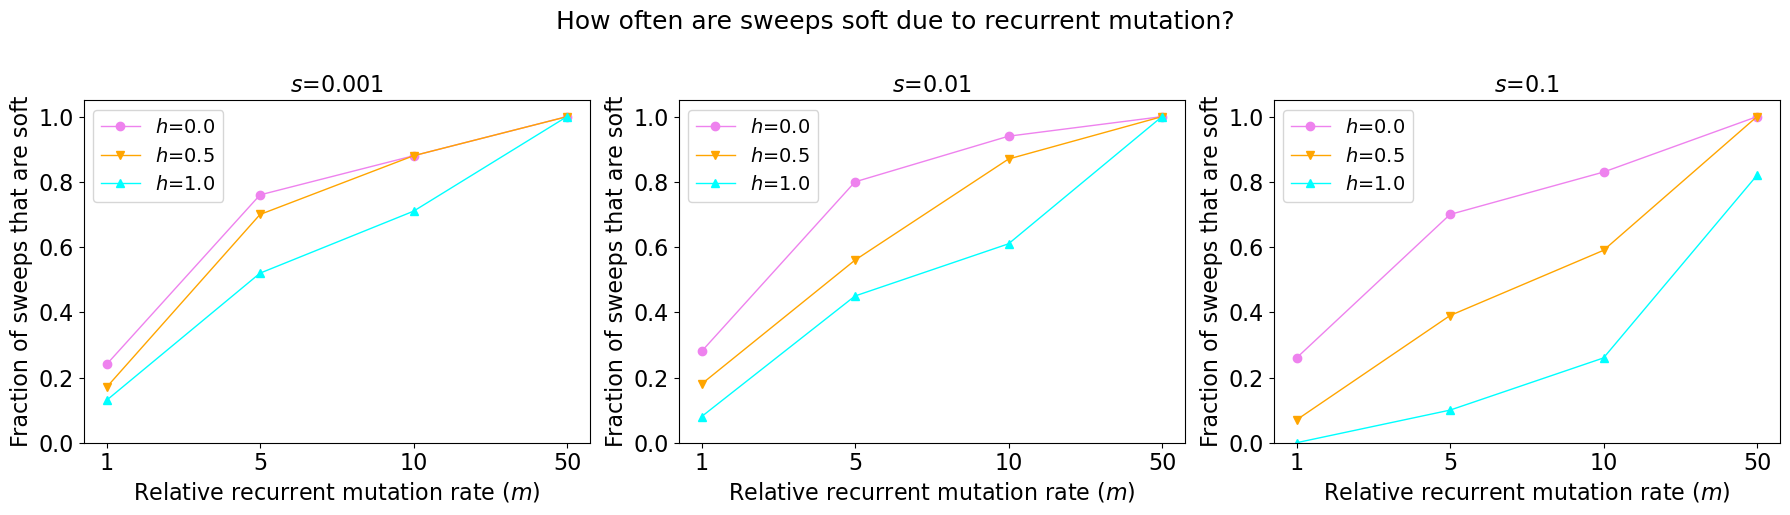

In [5]:
makeFig("How often are sweeps soft due to recurrent mutation?", 'Fraction Soft in Sample', "rm")

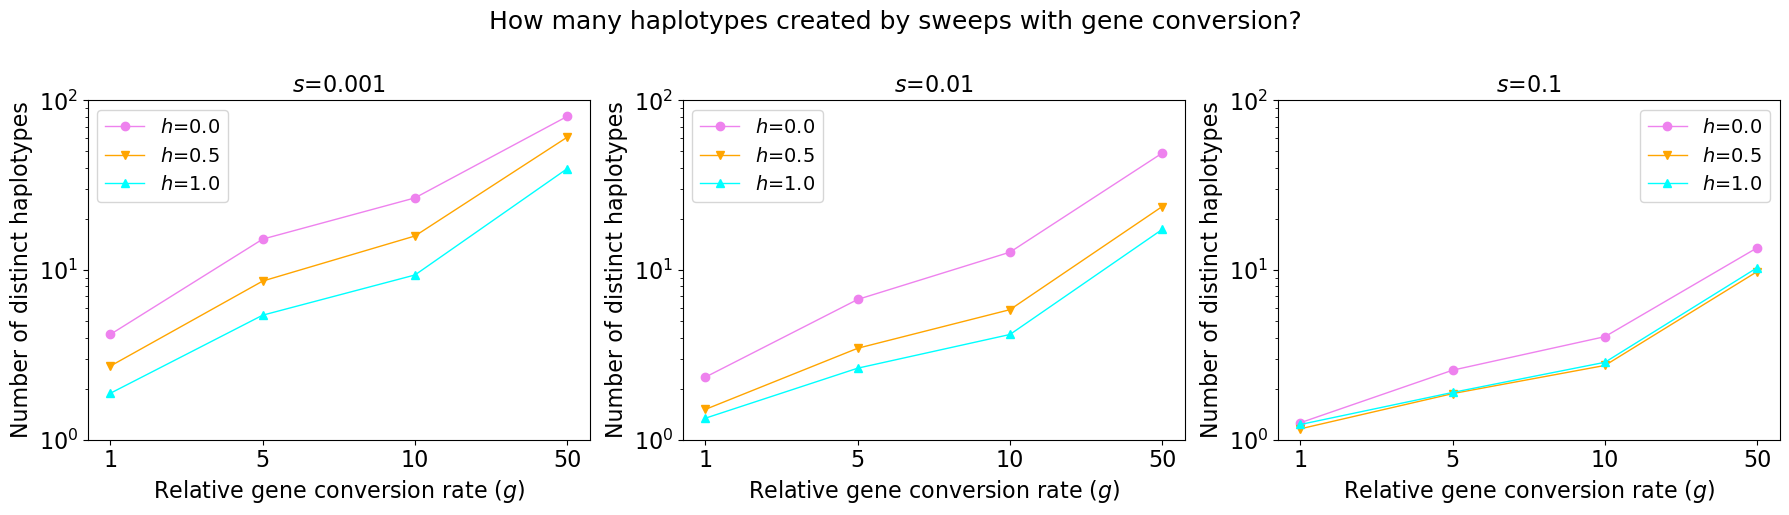

In [6]:
makeFig("How many haplotypes created by sweeps with gene conversion?", 'Mean k in Sample', "gc")

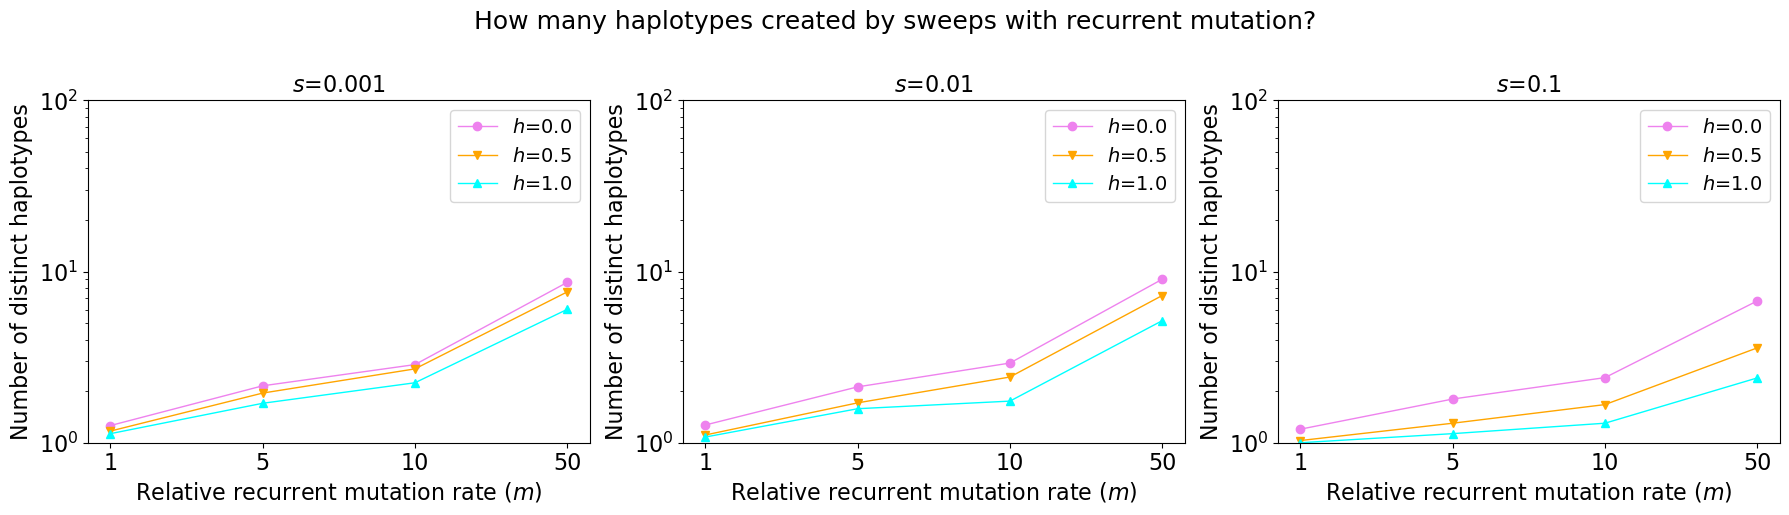

In [7]:
makeFig("How many haplotypes created by sweeps with recurrent mutation?", 'Mean k in Sample', "rm")

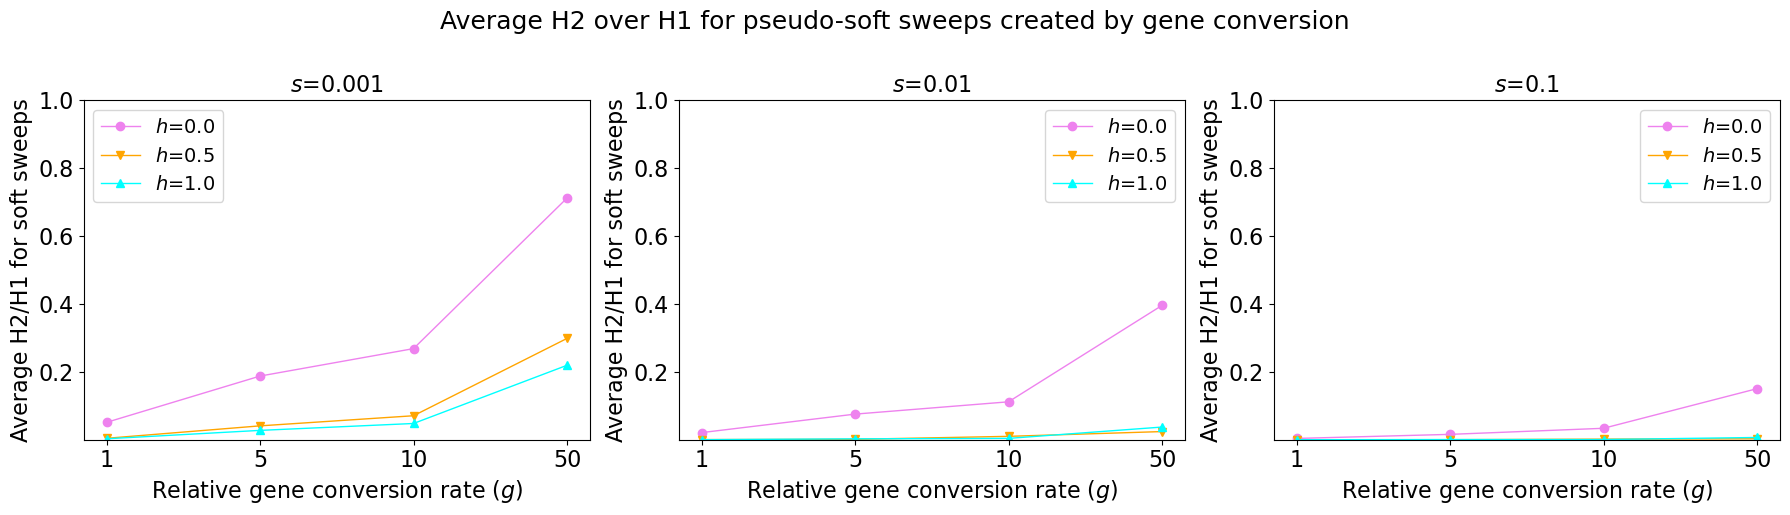

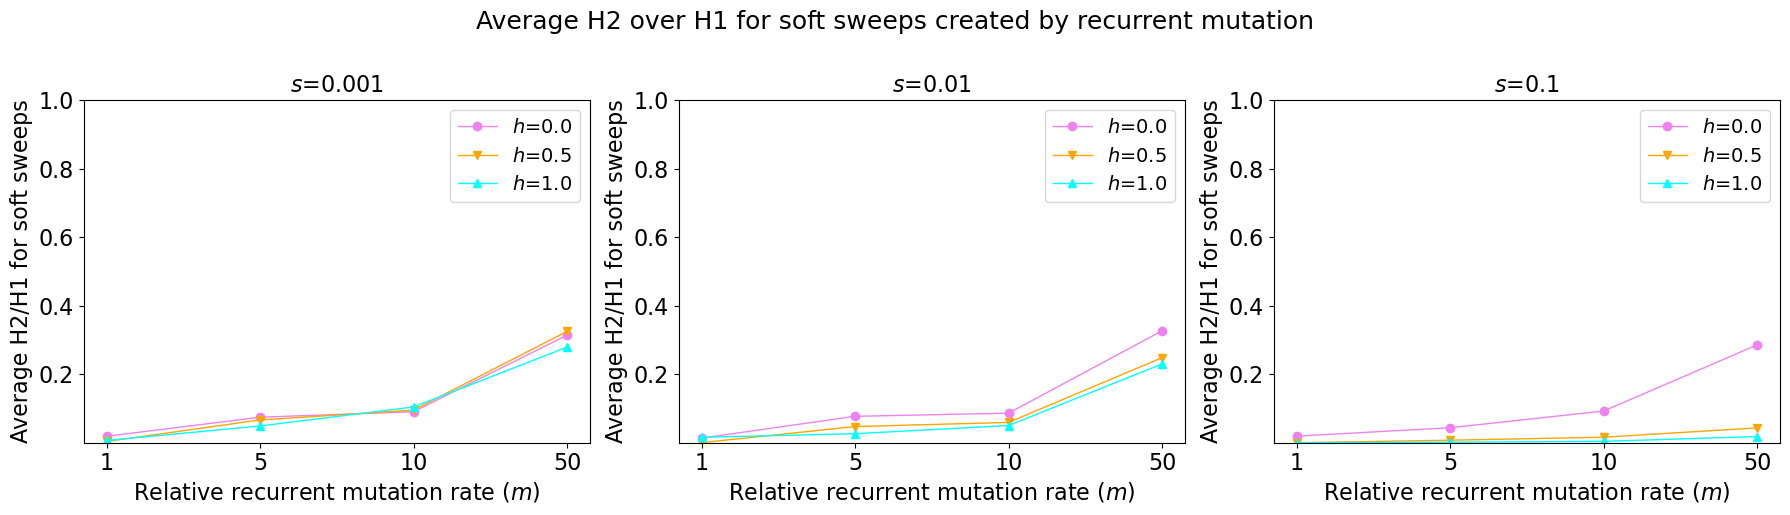

In [8]:
makeFig("Average H2 over H1 for pseudo-soft sweeps created by gene conversion", 'Mean H2/H1 Samp', "gc")
makeFig("Average H2 over H1 for soft sweeps created by recurrent mutation", 'Mean H2/H1 Samp', "rm")

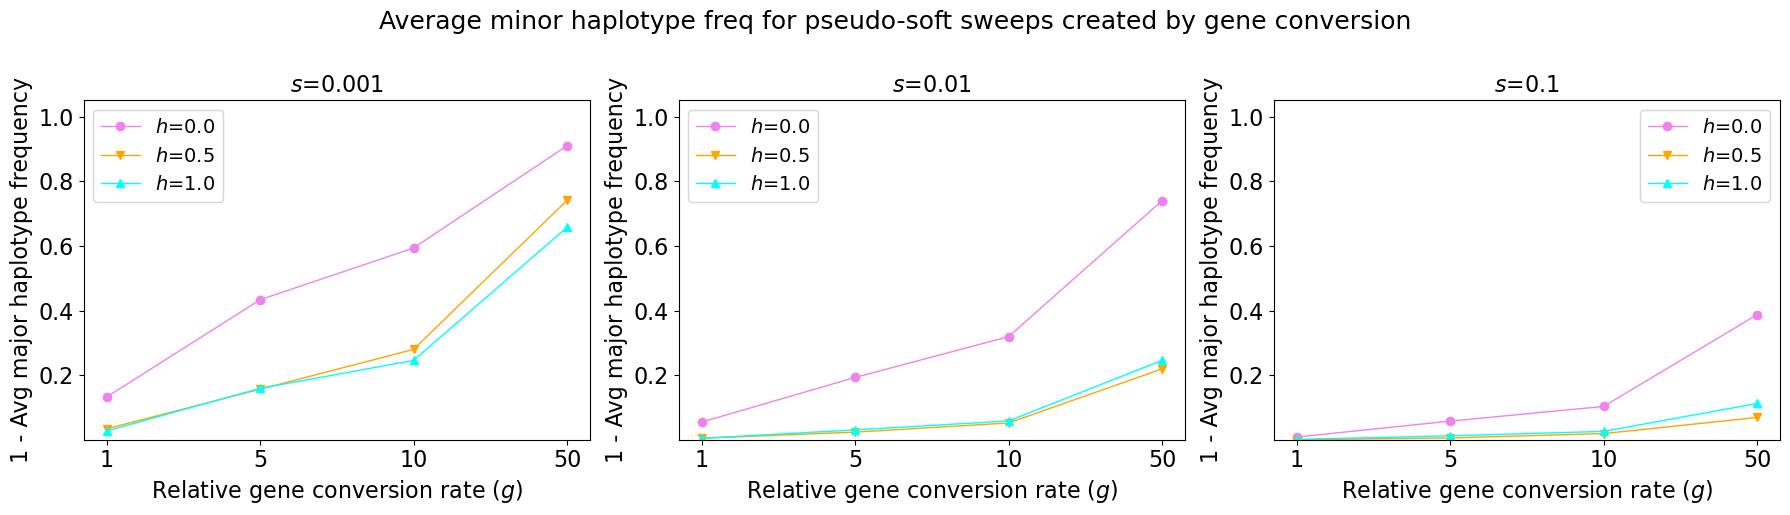

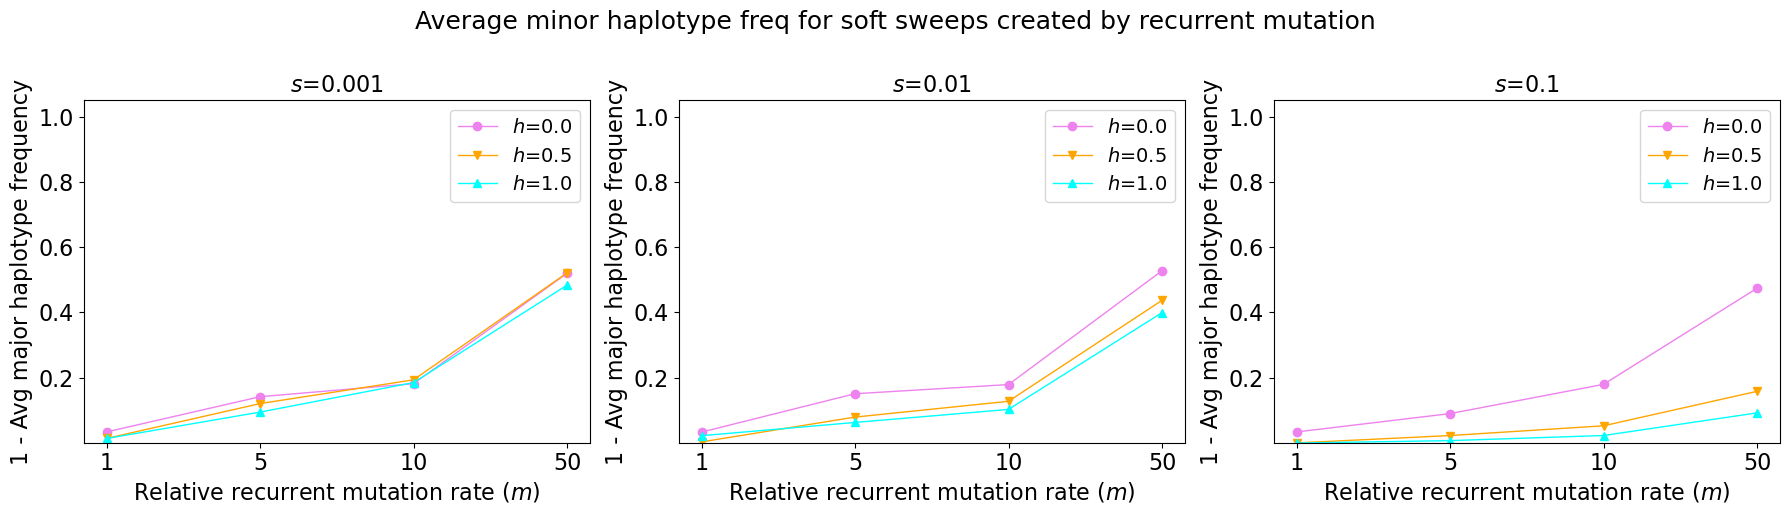

In [9]:
makeFig("Average minor haplotype freq for pseudo-soft sweeps created by gene conversion", 'Mean Sample Hap Maf', "gc")
makeFig("Average minor haplotype freq for soft sweeps created by recurrent mutation", 'Mean Sample Hap Maf', "rm")